In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Univariate Gaussian

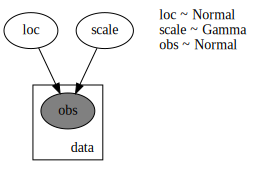

In [508]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints


loc = 5
scale = 10
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

def model(loc_prior_params, scale_prior_params, data):
    loc = pyro.sample("loc", dist.Normal(loc_prior_params[0], loc_prior_params[1]))
    scale = pyro.sample("scale", dist.Gamma(scale_prior_params[0], scale_prior_params[1]))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.Normal(loc, scale), obs=data)

pyro.render_model(model, model_args=([0.,4.], [1., 8.], data), render_params=True, render_distributions=True)

In [509]:
def parametrised_guide(loc_prior_params, scale_prior_params, data):
    mu_mu = pyro.param("mu_mu", torch.tensor(float(loc_prior_params[0])))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(float(loc_prior_params[1])), constraint=constraints.positive
    )
    
    std_a = pyro.param(
        "std_a", torch.tensor(scale_prior_params[0]), constraint=constraints.positive
    )
    
    std_b = pyro.param(
        "std_b", torch.tensor(scale_prior_params[1]), constraint=constraints.positive
    )

    loc = pyro.sample("loc", dist.Normal(mu_mu, mu_std))
    scale = pyro.sample("scale", dist.Normal(std_a, std_b))
    return pyro.sample("data_dist", dist.Normal(loc, scale))

### Train

Elbo loss: 4822.728974297729
Elbo loss: 3735.4773922505424
Elbo loss: 3733.6867405398034
Elbo loss: 3733.3403364283727
Elbo loss: 3741.4351769736368
Elbo loss: 3734.4309211953278
Elbo loss: 3734.0185388150458
Elbo loss: 3734.2359650404533
Elbo loss: 3734.726631110854
Elbo loss: 3734.4395686876996


CPU times: total: 3.42 s
Wall time: 3.5 s


Text(0, 0.5, 'ELBO loss')

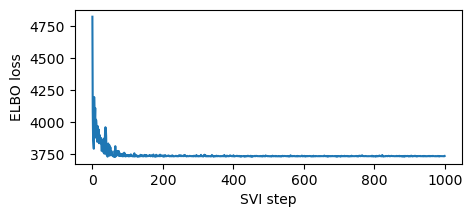

In [510]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step([0,10], [8, 1], data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [511]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

mu_mu 4.8981237
mu_std 0.30902335
std_a 9.906359
std_b 0.23245247


In [512]:
data.mean()

tensor(4.9337, dtype=torch.float64)

In [513]:
data.std()

tensor(10.1048, dtype=torch.float64)